In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [37]:
# In a first step, the input prices are loaded. We take day-ahead GErman spot market prices

df = pd.read_csv("./input/Hourly_EV_Charging.csv") # only for index, the actual EV data is handled separatel
df = df.iloc[:8760]

df_price = pd.read_excel("./input/Gro_handelspreise_201901010000_201912312359_Stunde.xlsx", skiprows=9)
df_p = pd.DataFrame()
df_p.index = df.index
# MWh prices are transformed to kWh prices
df_p["Deutschland/Luxemburg [€/kWh]"] = df_price["Deutschland/Luxemburg [€/MWh]"].apply(lambda x: x/1000).values
min_price = df_p["Deutschland/Luxemburg [€/kWh]"].min()
df_p["Deutschland/Luxemburg [€/kWh]"] = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x+abs(min_price)) # avoid negative values for optimization
df_p.head()

/Users/leosemmelmann/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Deutschland/Luxemburg [€/kWh]
0,0.11833
1,0.10008
2,0.08593
3,0.08010
4,0.08260


In [38]:

def settings_to_target_df(pricing_type, operation_type, feed_in_type,grid_charge_type, grid_charging_allowed,hp=False,ev=False,costs=False):
    target_df = pd.read_pickle(f"./output/00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
    if hp:
        target_df = pd.read_pickle(f"./output/detailed_consumption/HP_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
    elif ev:
        target_df = pd.read_pickle(f"./output/detailed_consumption/EV_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
    
    elif costs:
        target_df = pd.read_pickle(f"./output/detailed_financials/Costs_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")

    return target_df



In [39]:
def calculate_peaks_based_on_case(target_df, case):
    target_df["Sum"] = target_df.sum(axis=1)
    target_df = target_df[["Sum"]]
    heat_pump_peak_day = '2019-12-01'
    pv_peak_day = '2019-05-13'
    pv_peak = target_df["Sum"][pv_peak_day].abs().max()
    heat_pump_peak_day = '2019-12-01'
    hp_peak = target_df["Sum"][heat_pump_peak_day].abs().max()
    ev_peak_day = "2019-01-05"
    ev_peak = target_df["Sum"][ev_peak_day].abs().max()
    total_peak = target_df["Sum"].abs().max()
    
    case["worst_hp_day_peak_load"] = hp_peak
    case["worst_pv_day_peak_load"] = pv_peak
    case["worst_ev_day_peak_load"] = ev_peak
    case["worst_total_peak_load"] = total_peak
    
def calculate_agg_hp_consumption(target_df, case):
    target_df["Sum"] = target_df.sum(axis=1)
    total_hp_consumption = target_df["Sum"].sum()
    case["yearly_hp_consumption"] = total_hp_consumption
    
def calculate_agg_ev_consumption(target_df, case):
    target_df["Sum"] = target_df.sum(axis=1)
    total_ev_consumption = target_df["Sum"].sum()
    case["yearly_ev_consumption"] = total_ev_consumption

In [40]:

case_volumetric_fit_gcfalse_constant = {"name":"Constant Volumetric_FIT_GC False","feed_in_tariff" :"fit", "grid_charge_type" : "volumetric", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_volumetric_fit_gcfalse = {"name":"Dynamic Volumetric_FIT_GC False","feed_in_tariff" :"fit", "grid_charge_type" : "volumetric", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_volumetric_dynamic_gcfalse_constant = {"name":"Constant Volumetric_DynFeed_GC False","feed_in_tariff" :"dynamic", "grid_charge_type" : "volumetric", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_volumetric_dynamic_gcfalse = {"name":"Dynamic Volumetric_DynFeed_GC False","feed_in_tariff" :"dynamic", "grid_charge_type" : "volumetric", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_peak_fit_gcfalse_constant = {"name":"Constant Peak_FIT_GC False","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_peak_fit_gcfalse = {"name":"Dynamic Peak_FIT_GC False","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_peak_dynamic_gcfalse_constant = {"name":"Constant Peak_DynFeed_GC False","feed_in_tariff" :"dynamic", "grid_charge_type" : "peak", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_peak_dynamic_gcfalse = {"name":"Dynamic Peak_DynFeed_GC_GC False","feed_in_tariff" :"dynamic", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_rotating_fit_gcfalse_constant = {"name":"Constant Rotating_FIT_GC False","feed_in_tariff" :"dynamic", "grid_charge_type" : "rotating", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_rotating_fit_gcfalse = {"name":"Dynamic Rotating_FIT_GC False","feed_in_tariff" :"dynamic", "grid_charge_type" : "rotating", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_rotating_dynamic_gcfalse_constant = {"name":"Constant Rotating_DynFeed_GC False","feed_in_tariff" :"fit", "grid_charge_type" : "rotating", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_rotating_dynamic_gcfalse = {"name":"Dynamic Rotating_DynFeed_GC False","feed_in_tariff" :"fit", "grid_charge_type" : "rotating", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}





''' Old cases:
case_volumetric_dynamic_gctrue = {"name":"Dynamic Volumetric_DynFeed_GC True","feed_in_tariff" :"dynamic", "grid_charge_type" : "volumetric", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"True"}
case_volumetric_fit_gctrue_constant = {"name":"Constant Volumetric_FIT_GC True","feed_in_tariff" :"fit", "grid_charge_type" : "volumetric", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"True"}
case_peak_fit_gctrue_constant = {"name":"Constant Peak_FIT_GC True","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"True"}
case_peak_fit_gctrue = {"name":"Dynamic Peak_FIT_GC True","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"True"}
case_volumetric_fit_gcfalse = {"name":"Dynamic Volumetric_FIT_GC False","feed_in_tariff" :"fit", "grid_charge_type" : "volumetric", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_volumetric_fit_gctrue = {"name":"Dynamic Volumetric_FIT_GC True","feed_in_tariff" :"fit", "grid_charge_type" : "volumetric", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"True"}
case_peak_fit_gcfalse = {"name":"Dynamic Peak_FIT_GC False","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_peak_fit_gctrue = {"name":"Dynamic Peak_FIT_GC True","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"True"}
case_peak_dynamic_gctrue = {"name":"Dynamic Peak_DynFeed_GC_GC True","feed_in_tariff" :"dynamic", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"True"}

'''


cases = [case_volumetric_fit_gcfalse_constant, case_volumetric_fit_gcfalse, case_volumetric_dynamic_gcfalse_constant, case_volumetric_dynamic_gcfalse, case_peak_fit_gcfalse_constant, case_peak_fit_gcfalse, case_peak_dynamic_gcfalse_constant, case_peak_dynamic_gcfalse, case_rotating_fit_gcfalse_constant, case_rotating_fit_gcfalse, case_rotating_dynamic_gcfalse_constant, case_rotating_dynamic_gcfalse]
for case in cases: 
    target_df_consumption = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
                                                     case["grid_charging_allowed"])
    
    calculate_peaks_based_on_case(target_df_consumption, case)
    #target_df_hp = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
    #                                                 case["grid_charging_allowed"],hp=True)
    
    #calculate_agg_hp_consumption(target_df_hp,case)
    
    #target_df_ev = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
    #                                                 case["grid_charging_allowed"],ev=True)
    
    #calculate_agg_ev_consumption(target_df_ev,case)


In [41]:
cases_comparison = pd.DataFrame(cases).set_index("name")
cases_comparison

,feed_in_tariff,grid_charge_type,pricing_type,operation_type,grid_charging_allowed,worst_hp_day_peak_load,worst_pv_day_peak_load,worst_ev_day_peak_load,worst_total_peak_load
name,,,,,,,,,
Constant Volumetric_FIT_GC False,fit,volumetric,constant,dynamic,False,112.688206,89.135253,76.027510,148.960448
Dynamic Volumetric_FIT_GC False,fit,volumetric,dynamic,dynamic,False,223.876894,126.227320,179.991599,235.139754
Constant Volumetric_DynFeed_GC False,dynamic,volumetric,constant,dynamic,False,128.916878,97.293644,77.796756,149.881004
Dynamic Volumetric_DynFeed_GC False,dynamic,volumetric,dynamic,dynamic,False,223.876894,101.820585,179.991599,235.139754
Constant Peak_FIT_GC False,fit,peak,constant,dynamic,False,97.376233,81.892854,68.656956,142.060645
Dynamic Peak_FIT_GC False,fit,peak,dynamic,dynamic,False,131.809520,110.814019,119.134465,155.519933
Constant Peak_DynFeed_GC False,dynamic,peak,constant,dynamic,False,115.270088,149.190440,80.419813,161.178937
Dynamic Peak_DynFeed_GC_GC False,dynamic,peak,dynamic,dynamic,False,132.049714,136.040953,119.324685,161.178937
Constant Rotating_FIT_GC False,dynamic,rotating,constant,dynamic,False,135.079701,93.631988,115.349645,157.044162


In [42]:
cases_comparison[["worst_hp_day_peak_load","worst_pv_day_peak_load","worst_ev_day_peak_load","worst_total_peak_load"]].style.background_gradient(cmap='RdYlGn_r')

,worst_hp_day_peak_load,worst_pv_day_peak_load,worst_ev_day_peak_load,worst_total_peak_load
name,,,,
Constant Volumetric_FIT_GC False,112.688206,89.135253,76.027510,148.960448
Dynamic Volumetric_FIT_GC False,223.876894,126.227320,179.991599,235.139754
Constant Volumetric_DynFeed_GC False,128.916878,97.293644,77.796756,149.881004
Dynamic Volumetric_DynFeed_GC False,223.876894,101.820585,179.991599,235.139754
Constant Peak_FIT_GC False,97.376233,81.892854,68.656956,142.060645
Dynamic Peak_FIT_GC False,131.809520,110.814019,119.134465,155.519933
Constant Peak_DynFeed_GC False,115.270088,149.190440,80.419813,161.178937
Dynamic Peak_DynFeed_GC_GC False,132.049714,136.040953,119.324685,161.178937
Constant Rotating_FIT_GC False,135.079701,93.631988,115.349645,157.044162


In [43]:
'''cases_comparison[["yearly_hp_consumption"]].style.background_gradient(cmap='RdYlGn_r')

'''

'cases_comparison[["yearly_hp_consumption"]].style.background_gradient(cmap=\'RdYlGn_r\')\n\n'

In [44]:
'''cases_comparison[["yearly_ev_consumption"]].style.background_gradient(cmap='RdYlGn_r')

'''

'cases_comparison[["yearly_ev_consumption"]].style.background_gradient(cmap=\'RdYlGn_r\')\n\n'

# Comparing load patterns

In the following, we compare resulting aggregated load patterns by policies.

In [45]:
compare_df = pd.DataFrame()


for case in cases:
    target_df_consumption = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
                                                     case["grid_charging_allowed"])
    compare_df[case["name"]] = target_df_consumption.sum(axis=1)
    compare_df.index = target_df_consumption.index
    
compare_df["Deutschland/Luxemburg [€/kWh]"] = df_p["Deutschland/Luxemburg [€/kWh]"].values
compare_df.index = compare_df.index.strftime('%Y-%m-%d %H:%M:%S')


<ipython-input-46-bf7692da0923>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation=90)


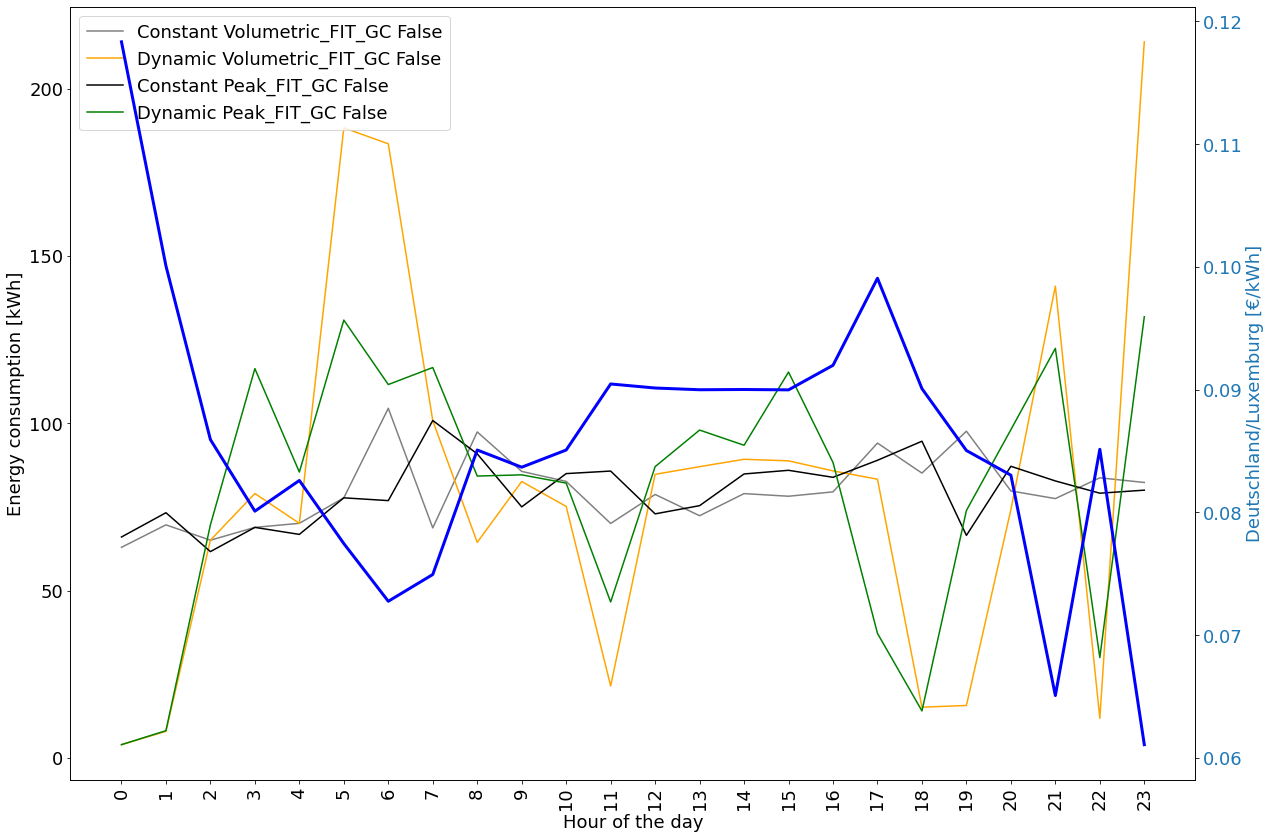

In [46]:
day = 0

fig, ax1 = plt.subplots()

plt.rcParams.update({'font.size': 18})
plt.rcParams["figure.figsize"] = (18,12)


color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Hour of the day')
ax1.set_ylabel('Energy consumption [kWh]', color="black")
ax1.plot(compare_df.index[day*24:(day+1)*24], compare_df['Constant Volumetric_FIT_GC False'].iloc[day*24:(day+1)*24], color="grey", label='Constant Volumetric_FIT_GC False')
ax1.plot(compare_df.index[day*24:(day+1)*24], compare_df['Dynamic Volumetric_FIT_GC False'].iloc[day*24:(day+1)*24], color="orange", label='Dynamic Volumetric_FIT_GC False')
ax1.plot(compare_df.index[day*24:(day+1)*24], compare_df['Constant Peak_FIT_GC False'].iloc[day*24:(day+1)*24], color="black", label='Constant Peak_FIT_GC False')
ax1.plot(compare_df.index[day*24:(day+1)*24], compare_df['Dynamic Peak_FIT_GC False'].iloc[day*24:(day+1)*24], color="green", label='Dynamic Peak_FIT_GC False')
ax1.tick_params(axis='y', labelcolor="black")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(compare_df.index[day*24:(day+1)*24], compare_df['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24],lw=3,color="blue")
ax2.tick_params(axis='y', labelcolor=color3)
ax1.set_xticklabels(ax1.get_xticks(), rotation=90)


fig.tight_layout()  # for a neat layout
plt.show()



In [51]:
### Comparing costs 
###### TODO: ROTATING NUMBERS ARE WRONG, STILL HAS TO BE IMPLEMENTED

costs = []

for case in cases:
    target_df_consumption = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
                                                     case["grid_charging_allowed"])

    # creating two data
    df_consumption = target_df_consumption.copy()
    df_feedin = target_df_consumption.copy()
    df_consumption[df_consumption < 0] = 0
    df_feedin[df_feedin > 0] = 0
    df_feedin = df_feedin.abs()
    
    if case["grid_charge_type"] == "volumetric":
        total_costs_grid = df_consumption.sum().sum()*0.0722
    elif case["grid_charge_type"] == "peak":
        total_costs_grid = df_consumption.max()*67.94
        total_costs_grid = total_costs_grid.sum()
        
    if case["pricing_type"]=="constant":
        total_costs_energy = df_consumption.sum()*(df_p.mean()[0])
        total_costs_energy = total_costs_energy.sum()
        pass
    elif case["pricing_type"]=="dynamic":
        total_costs_energy = (df_consumption.values*df_p.values).sum()
        
    if case["feed_in_tariff"] == "fit":
        total_feed_in_profits = ((df_feedin.sum()*(0.0722))).sum()
    elif case["feed_in_tariff"] == "dynamic":
        total_feed_in_profits = ((df_feedin.values*df_p.values)).sum()
    
    cost_case = {"name":case["name"],"Grid Costs":total_costs_grid,"Energy Costs":total_costs_energy,"Feed In Compensation":total_feed_in_profits,"Total Costs":total_costs_energy+total_costs_grid-total_feed_in_profits}
    costs.append(cost_case)

<AxesSubplot: xlabel='name'>

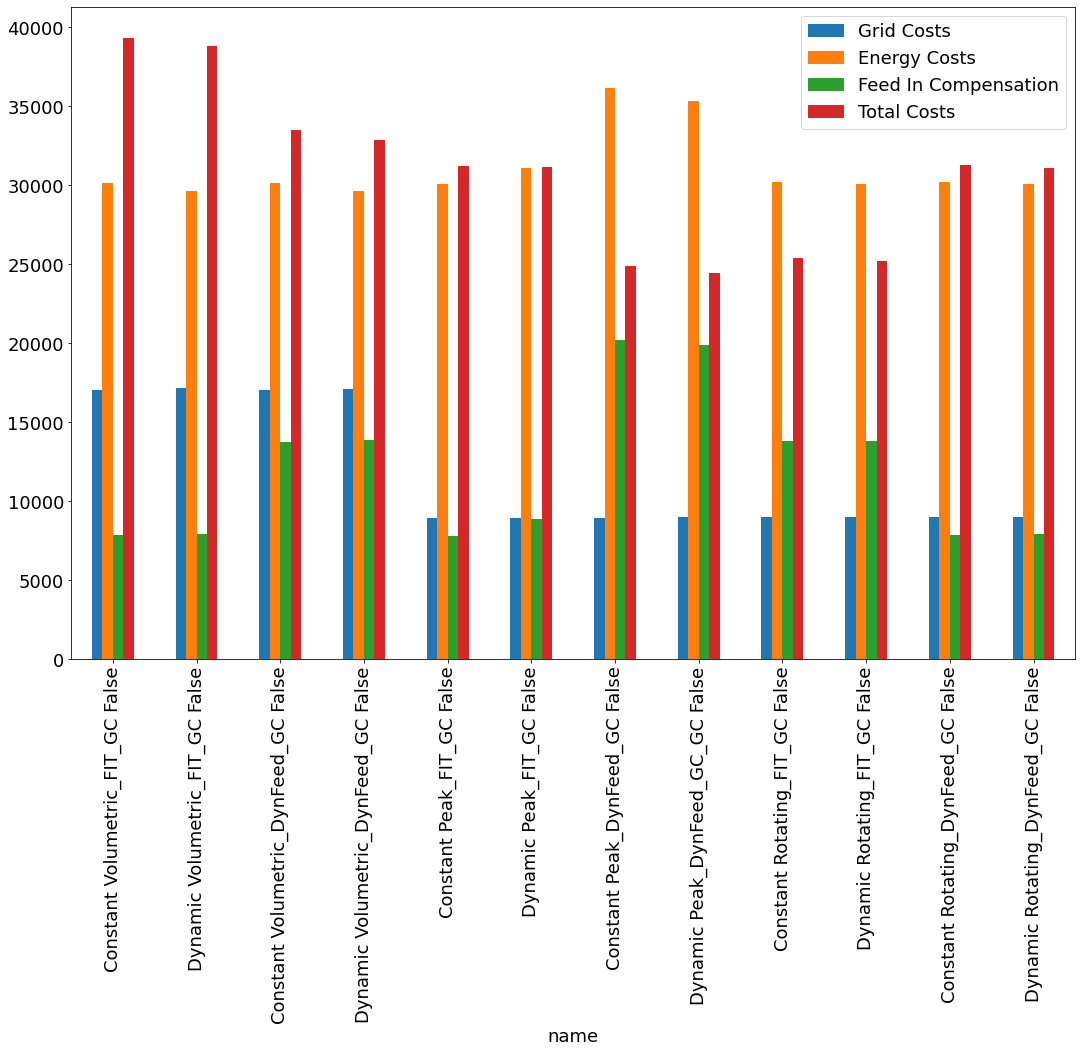

In [52]:
pd.DataFrame(costs).set_index("name").plot.bar()

<AxesSubplot: >

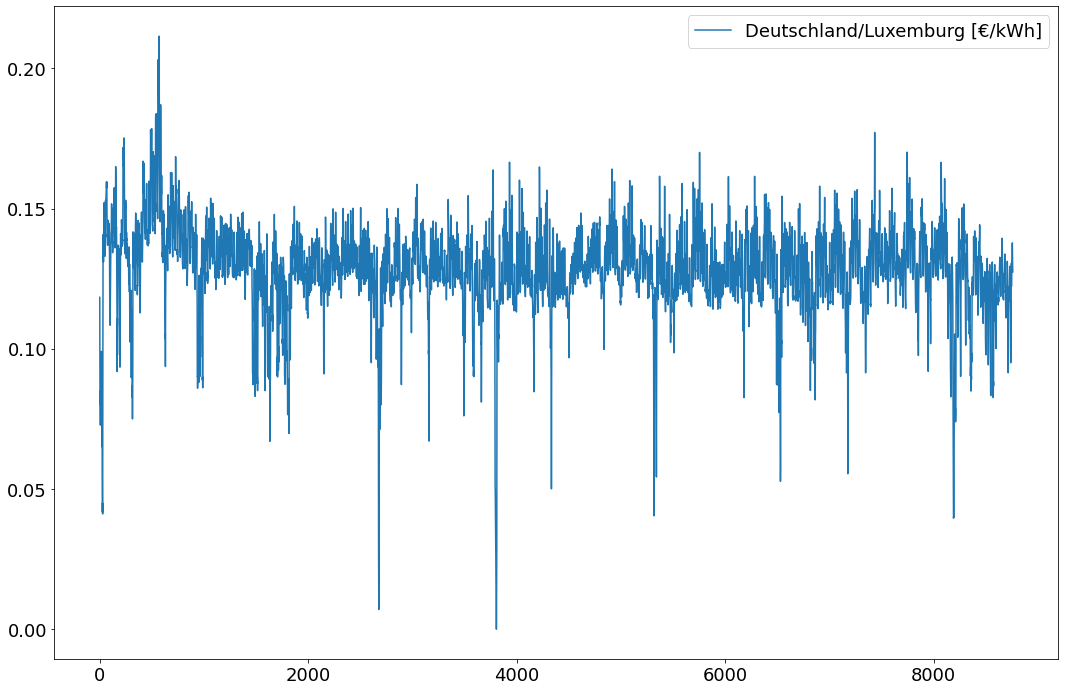

In [49]:
df_p.plot()